In [ ]:
!pip install dimod
!pip install pyqubo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 31.5 MB/s eta 0:00:00


In [ ]:
from math import sin, tan, sqrt, pow, asin, atanh, log, exp, pi, nan
import numpy as np
from scipy.optimize import minimize
import random
import dimod
from pyqubo import Binary, Array
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from itertools import product
import matplotlib.pyplot as plt


N=2
# Table, pag: 6
Cx_0 = 0.014 # -
k = 0.09 # -
Cz_max = 0.7 # -
S_REF = 120 # m^2 [L^2]
η = 0.06/3600 # kg(N.s)^-1 [L^-1 T]  seria lo inverso a una velocidad, verdad?
Zp_I = 10000 * 0.3048 # m [L]
Zp_F = 36000 * 0.3048 # m [L]

π = pi

m_I = 60000 # kg [M]
CAS_I = 250*0.5144444444444445 # m/s [LT^-1]
VMO = 350*0.5144444444444445 # m/s [LT^-1]
MMO = 0.82 # -
M_CRZ = 0.80 # -
L = 400000 # m [L]
s_F=L

Vz_min = 1.52400 # m/s
g_0 = 9.80665 # m/s^2 [LT^-2]
CI = 30/60 # kg/s [M T^-1] #documento

# Defs, pag: 3
m_0 = m_I # kg [M]
t_0 = 0 # s [T]
s_0 = 0 # m [L]
λ_0 = 1 # -

# Defs (2) pag: 4
Ts_0 = 288.15 # K
ρ_0 = 1.225 # kg.m^-3
L_z = -0.0065 # K.m^-1
g_0 = 9.80665 # m/s^2 [LT^-2]
R = 287.05287 # N.m.kg^-1.K^-1
α_0 = -g_0/R/L_z # "ecuacion"

def Fun(x):
    array_entrada = np.array(x)
    # Dividiendo el array por la mitad
    x1, x2 = np.array_split(array_entrada, 2)
    N=len (x1)+1
    x1 = np.array(x1)
    x2 = np.array(x2)

    def Zp(i): # m
        return Zp_I + i*(Zp_F - Zp_I)/(N)

    def F_N_MCL(i):   # aqui se fuerza a la descripcion del documento, el resultado simplemente esta en Newtos
        return 140000 - 2.53*Zp(i)/0.3048 # N

    def ρ(i):
        return ρ_0 * ((Ts_0 + L_z*Zp(i))/Ts_0)**(α_0 - 1) # kg/m^3

    def M(l): # Usando v = [250, 280, 310] para provar, aqui v esta en kts, M es adimencional (para antiguo codigo v=[128.611, 144.04432, 159.47764])
        return v[l]/sqrt(1.4*R*((Ts_0) + L_z*Zp(l)))

    def CAS(l): #Esta funcion siempre resulta en m/s
        #print (N,  v)
        arg = (7*R*Ts_0) * (((Ts_0/(Ts_0 + L_z*Zp(l)))**-α_0 *
                                 (pow((1 + (v[l]**2/(7*R*(Ts_0 + L_z*Zp(l))))),3.5) - 1) + 1)**(1/3.5) - 1)

        if arg < 0:
            #print (N, arg, v)
            return nan
        else:
            return sqrt(arg)

    #La siguiente es una verlocidad en m/s
    TAS_I = sqrt    (7*R*(Ts_0 + L_z*Zp_I) * ((((Ts_0 + L_z*Zp_I)/Ts_0)**-α_0 * ((1 + CAS_I**2/(7*R*Ts_0))**3.5 - 1) + 1)**(1/3.5) - 1))

    v_0 = TAS_I
    Cz_0 = m_0*g_0/(0.5*ρ(0)*v_0**2*S_REF) #Adimencional REVISADO
    #print("Cz_0",Cz_0)
    γ_0 = asin  ((F_N_MCL(0)-0.5*ρ(0)*v_0**2*S_REF*(Cx_0 + k*Cz_0))/(m_0*g_0))
    ρ_F = ρ_0 * ((Ts_0 + L_z*Zp_F)/Ts_0)**(α_0-1)
    v_F = M_CRZ * sqrt(1.4*R*(Ts_0 + L_z*Zp_F)) #m/s


    def Cz_ip(i): # Adimencional,  esta funcion debe retornar lo mismo que la del antiguo codigo ###recordar discrepancia por ρ(i)
        return (2 * m[i+1] * sin(γ[i+1]) * ((2 * γ[i+1] - 2 * γ[i]) / (Zp(i+1) - Zp(i)) - (ρ(i) * S_REF * Cz[i]) / (2 * m[i] * sin(γ[i])) \
                                            + g_0 / (v[i+1]**2 * tan(γ[i+1])) + g_0 / (v[i]**2 * tan(γ[i]))))/(ρ(i+1) * S_REF)


    def m_ip(i):

        A = (v[i+1]-v[i])/(Zp(i+1)-Zp(i))

        L = (-g_0/v[i+1] + (λ[i]*F_N_MCL(i))/(m[i]*v[i]*sin(γ[i]))
            - (0.5*ρ(i)*v[i]*S_REF*(Cx_0+k*Cz[i]**2))/(m[i]*sin(γ[i]))
            - g_0/v[i])

        H = (4*sin(γ[i+1])/(ρ(i+1)*S_REF)) * ((γ[i+1]-γ[i])/(Zp(i+1)-Zp(i)) +
            g_0/(2*v[i+1]**2*tan(γ[i+1])) - (ρ(i)*S_REF*Cz[i])/(4*m[i]*sin(γ[i])) +
            g_0/(2*v[i]**2*tan(γ[i])))

        I = (-2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (1/(Zp(i+1)-Zp(i)))

        J = (2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (m[i]/(Zp(i+1)-Zp(i))) - (v[i+1]*sin(γ[i+1])*λ[i]*F_N_MCL(i))/(F_N_MCL(i+1)*v[i]*sin(γ[i]))

        numerator_1 = (-2.0*A*v[i+1]*sin(γ[i+1]) + F_N_MCL(i+1)*I + L*v[i+1]*sin(γ[i+1]))
        numerator_2 = (2.0*sqrt(A**2*v[i+1]**2*sin(γ[i+1])**2 - A*F_N_MCL(i+1)*I*v[i+1]*sin(γ[i+1]) -
                                    A*L*v[i+1]**2*sin(γ[i+1])**2 - 0.25*Cx_0*H**2*S_REF**2*k*ρ(i+1)**2*v[i+1]**4 +
                                    0.25*F_N_MCL(i+1)**2*I**2 + 0.5*F_N_MCL(i+1)*H**2*J*S_REF*k*ρ(i+1)*v[i+1]**2 +
                                    0.5*F_N_MCL(i+1)*I*L*v[i+1]*sin(γ[i+1]) + 0.25*L**2*v[i+1]**2*sin(γ[i+1])**2))
        denominator = H**2*S_REF*k*ρ(i+1)*v[i+1]**2

        m_i_plus_1_positive = (numerator_1 + numerator_2)/denominator
        #m_i_plus_1_negative = (numerator_1 - numerator_2)/denominator

        return m_i_plus_1_positive #, m_i_plus_1_negative


    def m_ip(i): #para editar

        A = (v[i+1]-v[i])/(Zp(i+1)-Zp(i))

        L = (-g_0/v[i+1] + (λ[i]*F_N_MCL(i))/(m[i]*v[i]*sin(γ[i]))
            - (0.5*ρ(i)*v[i]*S_REF*(Cx_0+k*Cz[i]**2))/(m[i]*sin(γ[i]))
            - g_0/v[i])

        H = (4*sin(γ[i+1])/(ρ(i+1)*S_REF)) * ((γ[i+1]-γ[i])/(Zp(i+1)-Zp(i)) +
            g_0/(2*v[i+1]**2*tan(γ[i+1])) - (ρ(i)*S_REF*Cz[i])/(4*m[i]*sin(γ[i])) +
            g_0/(2*v[i]**2*tan(γ[i])))
        #print("Angulos",v[i])

        I = (-2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (1/(Zp(i+1)-Zp(i)))

        J = (2*v[i+1]*sin(γ[i+1])/(η*F_N_MCL(i+1))) * (m[i]/(Zp(i+1)-Zp(i))) - (v[i+1]*sin(γ[i+1])*λ[i]*F_N_MCL(i))/(F_N_MCL(i+1)*v[i]*sin(γ[i]))

        numerator_1 = (-2.0*A*v[i+1]*sin(γ[i+1]) + F_N_MCL(i+1)*I + L*v[i+1]*sin(γ[i+1]))
        numerator_2 = (2.0*sqrt(A**2*v[i+1]**2*sin(γ[i+1])**2 - A*F_N_MCL(i+1)*I*v[i+1]*sin(γ[i+1]) -
                                    A*L*v[i+1]**2*sin(γ[i+1])**2 - 0.25*Cx_0*H**2*S_REF**2*k*ρ(i+1)**2*v[i+1]**4 +
                                    0.25*F_N_MCL(i+1)**2*I**2 + 0.5*F_N_MCL(i+1)*H**2*J*S_REF*k*ρ(i+1)*v[i+1]**2 +
                                    0.5*F_N_MCL(i+1)*I*L*v[i+1]*sin(γ[i+1]) + 0.25*L**2*v[i+1]**2*sin(γ[i+1])**2))
        denominator = H**2*S_REF*k*ρ(i+1)*v[i+1]**2

        m_i_plus_1_positive = (numerator_1 + numerator_2)/denominator
        #m_i_plus_1_negative = (numerator_1 - numerator_2)/denominator
        #print("MMMMMMMMMMMMMM",m_i_plus_1_positive)
        return m_i_plus_1_positive #, m_i_plus_1_negative


    def s_ip(i):
        return s[i] + 0.5 * (Zp(i+1) / tan(γ[i+1]) + Zp(i+1) / tan(γ[i]) - Zp(i) / tan(γ[i+1]) - Zp(i) / tan(γ[i]))

    def t_ip(i):
        return t[i] + 0.5 * ((Zp(i+1) - Zp(i)) / (v[i+1] * sin(γ[i+1])) + (Zp(i+1) - Zp(i)) / (v[i] * sin(γ[i])))

    def λ_ip(i):
        term1 = -2 * (v[i+1] * sin(γ[i+1])) / (η * F_N_MCL(i+1))
        term2 = (m[i+1] - m[i]) / (Zp(i+1) - Zp(i))
        term3 = (v[i+1] * sin(γ[i+1]) * λ[i] * F_N_MCL(i)) / (F_N_MCL(i+1) * v[i] * sin(γ[i]))
        return (term1 * term2) - term3


    def λ_ip(i):
        term1 = -2 * (v[i+1] * sin(γ[i+1])) / (η * F_N_MCL(i+1))
        #term2 = (m[i+1] - m[i]) / (Zp(i+1) - Zp(i))
        term2 = (m[i+1] - m[i]) / (Zp(i+1) - Zp(i))
        term3 = (v[i+1] * sin(γ[i+1]) * λ[i] * F_N_MCL(i)) / (F_N_MCL(i+1) * v[i] * sin(γ[i]))
#        print("Term",(term1 * term2))
        #print("Term",(term1 * term2) + term3)
        #print("v1",v[i+1],sin(γ[i+1]),γ[i+1])
        return (term1 * term2) - term3




    def Θ(N_,_𝑣,γ_):
        global N, v, γ, m, s, t, 𝜆, Cz, v_, P
        N=N_ ; P=True ; v=_𝑣; γ=γ_#; v_=v[N-1]

        m = [m_0]; s=[s_0]; t=[t_0]; 𝜆=[𝜆_0]; Cz=[Cz_0]
        Cz_i = Cz_0
        for i in range (0, N-1, 1):
            if len(v) <= (i+1) or v[i+1]*sin(γ[i+1]) < Vz_min or CAS(i+1) > VMO : P=False; N = i+1; break
            #print("valores", v[i+1] * sin(γ[i+1]),"<",Vz_min, CAS(i+1),">",VMO, "sin(γ1) = ",sin(γ[i+1]),γ[i+1],v[i+1])
            #valores 5.592087010043378 < 1.524 134.10122185475828 > 180.05555555555557 sin(γ1) =  0.029666244085110757 0.029670597283903602
            m.append(m_ip(i))
            Cz.append(Cz_ip (i))
            𝜆.append(𝜆_ip(i))
            s.append(s_ip(i))
            t.append(t_ip(i))


            if (𝜆[i+1] > 1 or 𝜆[i+1] < 0) or (Cz[i+1] > Cz_max or M(i+1) > MMO):
                P=False; break
        return

    #print("P=", P," N=",N)

    def A():
        #print("Buscando_A",(-ρ_F * S_REF * Cx_0) / (2 * m[N-1]) - (6 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**4))
        #print("ρ_F",ρ_F)
        #print("Buscando_A",(-ρ_F * S_REF * Cx_0) / (2 * m[N-1]) - (6 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**4))# / (2 * m[N-1]) - (6 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**4))
        #print("ρ_F",ρ_F)
        return (-ρ_F * S_REF * Cx_0) / (2 * m[N-1]) - (6 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**4)

    def B():

        return (16 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**3)

    def C():
        #print("Buscando_C",(F_N_MCL(N-1) / m[N-1]) - (12 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**2))
        return (F_N_MCL(N-1) / m[N-1]) - (12 * k * m[N-1] * g_0**2) / (ρ_F * S_REF * v[N-1]**2)

    def D(A, B, C):
        return (B**2 - 4 * A * C)**0.5

    def t_B():
        global kuo45789
        kuo45789 = (2/D(A(), B(), C())) * (atanh((2*A()*v[N-1] + B())/D(A(), B(), C())) - atanh((2*A()*v_F + B())/D(A(), B(), C())))
        return t[N-1] + kuo45789

    def m_B(): ### Aqui hay un recalculo de una funcion, se podria optimizar?
        #print("Buscando",t_B() )
        return m[N-1] - η * 𝜆[N-1] * F_N_MCL(N-1) * (t_B() - t[N-1])

    def s_B():
        return s[N-1] + (1/A()) * log((D(A(), B(), C())-2*A()*v_F-B())/(D(A(), B(), C())-2*A()*v[N-1]-B())) - (B()+D(A(), B(), C()))/(2*A()) * (t_B() - t[N-1])

    def m_F():
        return m_B() * exp((-2 * η * g_0 * sqrt(k * Cx_0) / v_F) * (s_F - s_B()))

    def t_F():
        return t_B() + (s_F - s_B()) / v_F

    def φ(v,γ):
        Θ(N,v,γ)
        if P == True:
            return  -m_F()  + CI*(t_B() - s_B()/v_F)
        else:
            return nan

    return φ(np.concatenate(([v_0], x1)), np.concatenate(([γ_0], x2*π/180)))

def FF(x):
    a = -Fun(x)
    if a > 0:
        return a
    else:
        return 58626 # Valor mas alto en la funcion

def fun(x, y):
    if np.isscalar(x) and np.isscalar(y):
        return FF([x, y])
    else:
        coords = np.stack((x, y), axis=-1)
        vectorized_funn = np.vectorize(FF, signature='(n)->()')
        return vectorized_funn(coords)


In [ ]:
f = fun
f_min = 50000    # Valor mínimo permitido
f_max = 58625.9   # Valor máximo permitido

class Hexagon:
    def __init__(self, q, r):
        self.q = q
        self.r = r

    def __hash__(self):
        return hash((self.q, self.r))

    def __eq__(self, other):
        return self.q == other.q and self.r == other.r

    def to_cartesian(self, width, height):
        """
        Convierte las coordenadas axiales a cartesianas con deformación.
        Los factores están ajustados para garantizar que los hexágonos se toquen.
        """
        x = width * (self.q * 1.5)
        y = height * (self.r * 2 + self.q)
        return np.array([x, y])

    @staticmethod
    def from_cartesian(x, y, width, height):
        """
        Convierte coordenadas cartesianas a coordenadas axiales.
        """
        q = (x / width) / 1.5
        r = (y / height - q) / 2

        q_rounded = round(q)
        r_rounded = round(r)
        s_rounded = round(-q_rounded - r_rounded)

        if q_rounded + r_rounded + s_rounded != 0:
            q_diff = abs(q - q_rounded)
            r_diff = abs(r - r_rounded)
            s_diff = abs(-q - r - s_rounded)
            if q_diff > r_diff and q_diff > s_diff:
                q_rounded = -r_rounded - s_rounded
            elif r_diff > s_diff:
                r_rounded = -q_rounded - s_rounded
            else:
                s_rounded = -q_rounded - r_rounded

        return Hexagon(q_rounded, r_rounded)

    def vecinos(self):
        """
        Genera los 6 vecinos de un hexágono en coordenadas axiales.
        """
        directions = [
            Hexagon(1, 0), Hexagon(1, -1), Hexagon(0, -1),
            Hexagon(-1, 0), Hexagon(-1, 1), Hexagon(0, 1)
        ]
        return [Hexagon(self.q + d.q, self.r + d.r) for d in directions]

# Parámetros configurables
hex_width = 0.9   # Ancho del hexágono
hex_height = 0.09  # Alto del hexágono

hexagonos_dibujados = set()
centros_hexagonos_cartesianos = []
coordenada_inicial_cartesiana = (188, 1.7)
centro_inicial = Hexagon.from_cartesian(*coordenada_inicial_cartesiana, hex_width, hex_height)
hexagonos_dibujados.add(centro_inicial)
lista_hexagonos_por_agregar = centro_inicial.vecinos()

NUM_HEXAGONOS_POR_ITERACION = 6

# Lógica principal sin visualización
while lista_hexagonos_por_agregar:
    seleccionados = random.sample(
        lista_hexagonos_por_agregar,
        min(NUM_HEXAGONOS_POR_ITERACION, len(lista_hexagonos_por_agregar))
    )

    for hex_a_agregar in seleccionados:
        lista_hexagonos_por_agregar.remove(hex_a_agregar)

        if hex_a_agregar in hexagonos_dibujados:
            continue

        x, y = hex_a_agregar.to_cartesian(hex_width, hex_height)

        f_val = f(x, y)
        if not (f_min <= f_val <= f_max):
            continue

        hexagonos_dibujados.add(hex_a_agregar)
        centros_hexagonos_cartesianos.append([x, y])

        for vecino in hex_a_agregar.vecinos():
            if vecino not in hexagonos_dibujados and vecino not in lista_hexagonos_por_agregar:
                x_vec, y_vec = vecino.to_cartesian(hex_width, hex_height)
                f_vec = f(x_vec, y_vec)
                if f_min <= f_vec <= f_max:
                    lista_hexagonos_por_agregar.append(vecino)

# Entregar los puntos finales
puntos = np.array(centros_hexagonos_cartesianos)
print("Puntos Encontrados con el metodo de hexagonos 2D:")
print(puntos)

Puntos Encontrados con el metodo de hexagonos 2D:
[[186.3    1.62]
 [189.     1.8 ]
 [187.65   1.53]
 ...
 [156.6    7.74]
 [153.9    7.74]
 [155.25   7.83]]


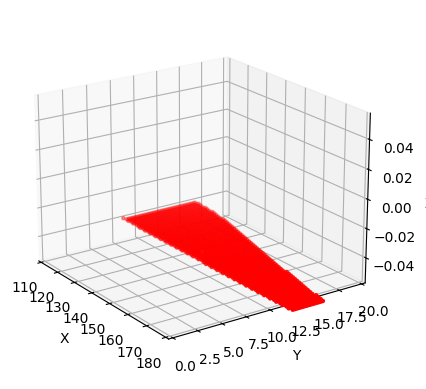

In [ ]:
x = [punto[0] for punto in puntos]
y = [punto[1] for punto in puntos]
z = [0] * len(puntos)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([110, 180])
ax.set_ylim([0, 20])

ax.view_init(elev=20, azim=-35) # Ajusta estos valores para rotar la vista
plt.show()

In [ ]:
def chebyshev_polynomial(n, x):
    """Generate symbolic Chebyshev polynomial of degree n"""
    if n == 0:
        return sp.Integer(1)
    elif n == 1:
        return x
    else:
        return 2 * x * chebyshev_polynomial(n - 1, x) - chebyshev_polynomial(n - 2, x)

def scale_to_chebyshev(x, interval):
    """Scale x from [a,b] to [-1,1]"""
    a, b = interval
    return 2 * (x - a) / (b - a) - 1

def polinomio_de_cheb(f, p, g):
    """
    Genera un polinomio de Chebyshev de grado g que aproxima la función f usando los puntos en p.

    Parámetros:
    - f: función original que se desea aproximar.
    - p: lista de puntos a utilizar para la aproximación.
    - g: grado del polinomio de Chebyshev.

    Retorna:
    - Un polinomio simbólico de Chebyshev en términos de x1, x2, ..., xn.
    """
    # Deduce el número de variables (dimensión) a partir del primer punto en p
    num_vars = len(p[0])
    variables = sp.symbols(f'x1:{num_vars + 1}')  # Crea x1, x2, ..., xn

    # Determina los intervalos de cada variable en los puntos p
    intervals = [(min([point[i] for point in p]), max([point[i] for point in p])) for i in range(num_vars)]

    # Escala los puntos en p al espacio [-1, 1] usando los intervalos determinados
    points_cheb = np.array([
        [scale_to_chebyshev(point[i], intervals[i]) for i in range(num_vars)]
        for point in p
    ])

    # Evalúa la función en cada punto en p
    f_values = np.array([f(*point) for point in p])

    # Construye la matriz de Vandermonde en el espacio de Chebyshev
    num_terms = sum(1 for i in range(g + 1) for j in range(g + 1) if i + j <= g)
    V = np.zeros((len(p), num_terms))
    idx = 0
    for indices in product(range(g + 1), repeat=num_vars):
        if sum(indices) <= g:
            term_val = np.ones(len(p))
            for var_index, degree in enumerate(indices):
                term_val *= np.polynomial.chebyshev.chebval(points_cheb[:, var_index], [0] * degree + [1])
            V[:, idx] = term_val
            idx += 1

    # Resuelve el sistema usando mínimos cuadrados
    coeffs = np.linalg.lstsq(V, f_values, rcond=None)[0]

    # Construye el polinomio simbólico en términos de las variables
    expr = sp.Integer(0)
    idx = 0
    for indices in product(range(g + 1), repeat=num_vars):
        if sum(indices) <= g:
            term = coeffs[idx]
            for var_index, degree in enumerate(indices):
                term *= chebyshev_polynomial(degree, scale_to_chebyshev(variables[var_index], intervals[var_index]))
            expr += term
            idx += 1

    # Simplifica la expresión simbólica
    expr = sp.simplify(expr)
    return expr


In [ ]:
polinomio_de_cheb(fun, puntos, 5)

8.28325303464805e-8*x1**5 + 7.09511308127866e-8*x1**4*x2 - 8.63846018064648e-5*x1**4 + 2.51290548650455e-5*x1**3*x2**2 - 0.000233741230713028*x1**3*x2 + 0.0364709512362595*x1**3 + 0.00173560277168354*x1**2*x2**3 - 0.0338983635803079*x1**2*x2**2 + 0.191006950460823*x1**2*x2 - 7.87497776017214*x1**2 + 0.0499426924226038*x1*x2**4 - 1.44456705428661*x1*x2**3 + 14.6331795978389*x1*x2**2 - 60.3584316044867*x1*x2 + 885.143956000652*x1 + 0.449738114492448*x2**5 - 18.6529992617484*x2**4 + 283.851768972644*x2**3 - 2003.56679330744*x2**2 + 6598.0796392886*x2 + 16039.5115250941

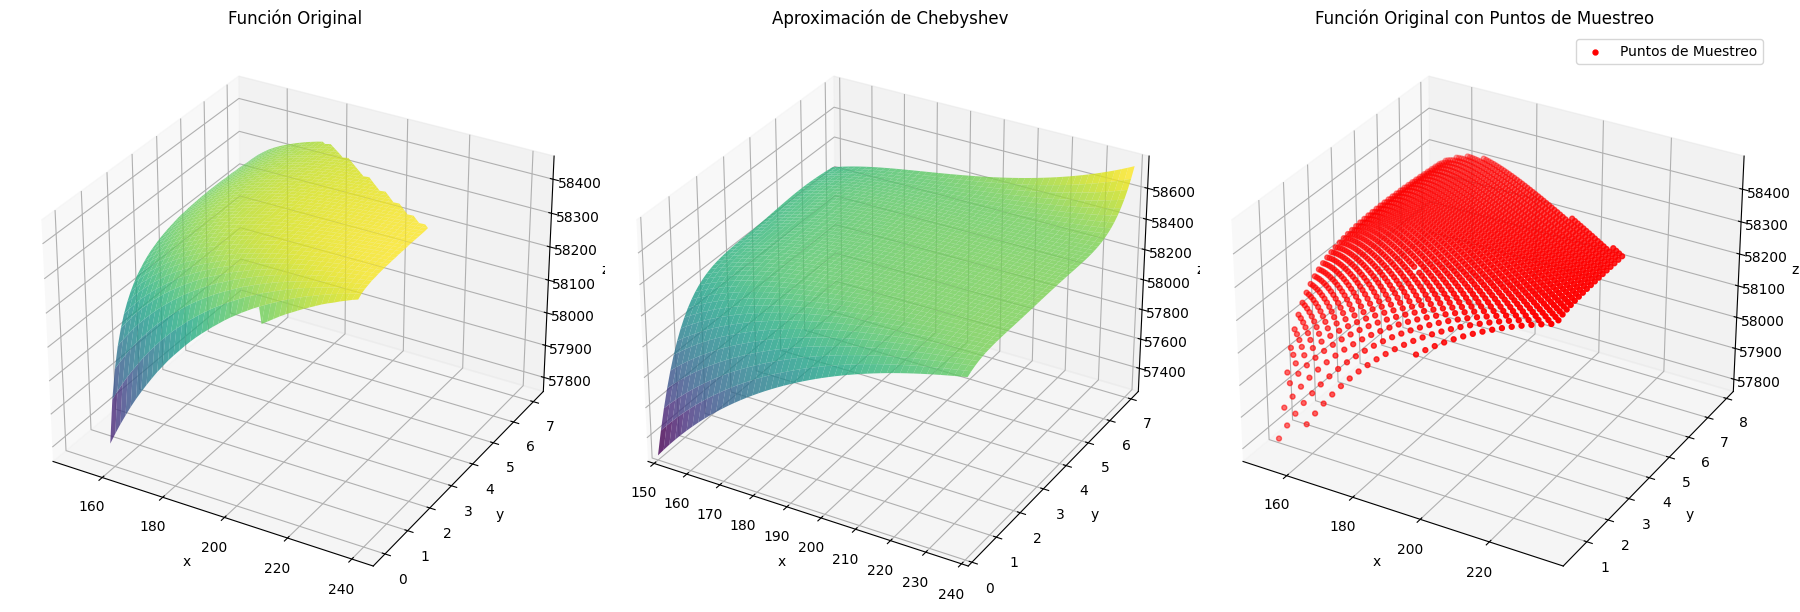

In [ ]:
f_example = fun
grado = 5

# Obtener el polinomio de Chebyshev usando el código anterior
polinomio_chebyshev = polinomio_de_cheb(f_example, puntos, grado)

# Crear la función evaluable a partir del polinomio de Chebyshev
x1, x2 = sp.symbols('x1 x2')

polinomio_func = sp.lambdify((x1, x2), polinomio_chebyshev, 'numpy')

# Intervalo para la gráfica
interval_x = (0, 10)
interval_y = (0, 10)



#(f_prueba, [188, 1.7], [[110,250],[0,20]],100, 10, 0.1)



interval_x = (150, 240)
interval_y = (0, 7)

#interval_z = (-2, 3)

resolucion = 50  # número de puntos en cada eje

# Generar malla para graficar
x_vals = np.linspace(*interval_x, resolucion)
y_vals = np.linspace(*interval_y, resolucion)
X, Y = np.meshgrid(x_vals, y_vals)

# Evaluar función original en la malla
Z_original = f_example(X, Y)
umbral = 58500  # Define tu umbral
# Reemplaza valores mayores al umbral con np.nan
Z_original = np.where(Z_original > umbral, np.nan, Z_original)


# Evaluar el polinomio de Chebyshev en la malla
Z_chebyshev = polinomio_func(X, Y)

# Graficar

fig = plt.figure(figsize=(18, 6))

# 1. Gráfica de la función original
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_original, cmap='viridis', alpha=0.8)
ax1.set_title('Función Original')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
###ax1.set_zlim(interval_z)

# 2. Gráfica del polinomio de Chebyshev
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_chebyshev, cmap='viridis', alpha=0.8)
ax2.set_title('Aproximación de Chebyshev')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_ylim(0,7.2)
ax2.set_xlim(150,240)
#ax2.set_zlim((53850,53900))

# 3. Gráfica de la función original con los puntos de muestreo resaltados
ax3 = fig.add_subplot(133, projection='3d')
#surf3 = ax3.plot_surface(X, Y, Z_original, cmap='viridis', alpha=0.8)
ax3.scatter([p[0] for p in puntos], [p[1] for p in puntos],
            [f_example(p[0], p[1]) for p in puntos],
            color='red', marker='.',s=50, label='Puntos de Muestreo')
ax3.set_title('Función Original con Puntos de Muestreo')
ax3.set_xlabel('x')
###ax3.set_ylabel('y')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.legend()
#ax3.set_zlim((53882.210441140224,53882.210441140226))
#53882.210441140225
###ax3.set_zlim(interval_z)

plt.tight_layout()
plt.show()


In [ ]:
def funcion_objetivo(x1, x2):
    return (
        8.28325303464805e-8 * x1**5 +
        7.09511308127866e-8 * x1**4 * x2 -
        8.63846018064648e-5 * x1**4 +
        2.51290548650455e-5 * x1**3 * x2**2 -
        0.000233741230713028 * x1**3 * x2 +
        0.0364709512362595 * x1**3 +
        0.00173560277168354 * x1**2 * x2**3 -
        0.0338983635803079 * x1**2 * x2**2 +
        0.191006950460823 * x1**2 * x2 -
        7.87497776017214 * x1**2 +
        0.0499426924226038 * x1 * x2**4 -
        1.44456705428661 * x1 * x2**3 +
        14.6331795978389 * x1 * x2**2 -
        60.3584316044867 * x1 * x2 +
        885.143956000652 * x1 +
        0.449738114492448 * x2**5 -
        18.6529992617484 * x2**4 +
        283.851768972644 * x2**3 -
        2003.56679330744 * x2**2 +
        6598.0796392886 * x2 +
        16039.5115250941
    )

Optimizando función cuadrática usando D-Wave...

Mejor solución encontrada:
x = 150.0880
y = 0.0342
f(x,y) = 57310.5501


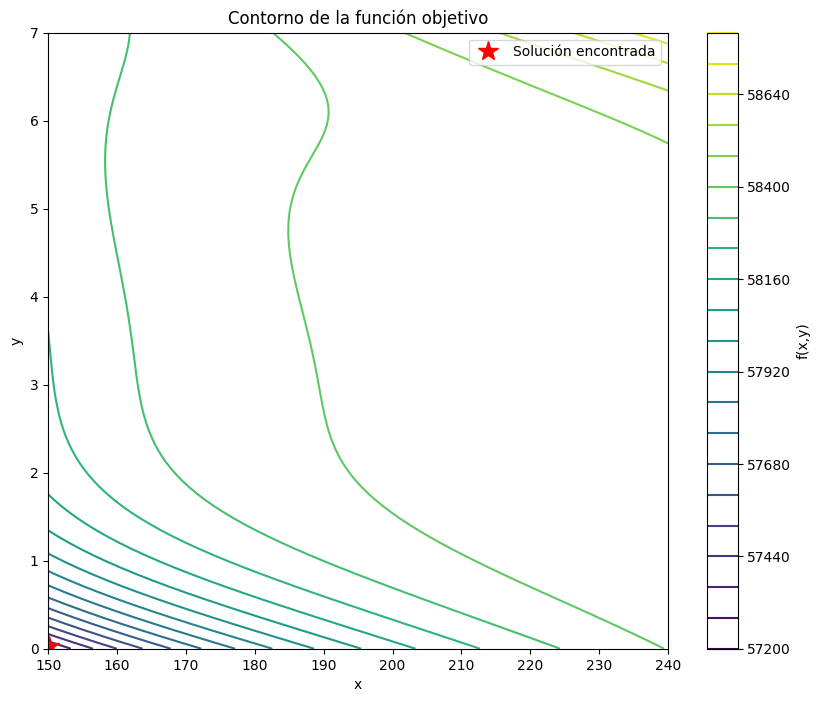

In [ ]:
def visualizar_funcion(x_valor, y_valor): #  Se pasan x_valor e y_valor para graficarlos.
    x = np.linspace(150, 240, 100)
    y = np.linspace(0, 7, 100)
    X, Y = np.meshgrid(x, y)
    Z = funcion_objetivo(X, Y)

    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, Z, levels=20)
    plt.colorbar(label='f(x,y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contorno de la función objetivo')
    plt.plot(x_valor, y_valor, 'r*', markersize=15, label='Solución encontrada') #  Graficar el punto encontrado.
    plt.legend()
    plt.show()

def crear_qubo(num_bits=4): # Parámetro para el número de bits
    x_bits = Array.create('x', shape=num_bits, vartype='BINARY') #Usar array de PyQUBO facilita la suma.
    y_bits = Array.create('y', shape=num_bits, vartype='BINARY')

    x_min, x_max = 150, 240
    y_min, y_max = 0, 7

    x_scale = (x_max - x_min) / (2**num_bits - 1)
    y_scale = (y_max - y_min) / (2**num_bits - 1)

    x = x_min + x_scale * sum(2**i * x_bits[i] for i in range(num_bits))
    y = y_min + y_scale * sum(2**i * y_bits[i] for i in range(num_bits))

    #H = 3.00755171107551*x + 23.4759463762618*y + 57739.0525970849
    H = funcion_objetivo(x, y)

    model = H.compile()
    bqm = model.to_bqm()

    return bqm

def resolver_y_mostrar_resultados(num_bits=4, num_reads=1000):  #  Parámetros para bits y lecturas
    bqm = crear_qubo(num_bits)

    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads) # Usar num_reads

    mejor_muestra = sampleset.first.sample

    x_min, x_max = 150, 240
    y_min, y_max = 0, 7

    x_scale = (x_max - x_min) / (2**num_bits - 1)
    y_scale = (y_max - y_min) / (2**num_bits - 1)

    x_valor = x_min + x_scale * sum(2**i * mejor_muestra[f'x[{i}]'] for i in range(num_bits)) #  Acceso al array con [i].
    y_valor = y_min + y_scale * sum(2**i * mejor_muestra[f'y[{i}]'] for i in range(num_bits)) #  Acceso al array con [i].


    print(f"\nMejor solución encontrada:")
    print(f"x = {x_valor:.4f}")
    print(f"y = {y_valor:.4f}")
    print(f"f(x,y) = {funcion_objetivo(x_valor, y_valor):.4f}")

    visualizar_funcion(x_valor, y_valor) #  Se pasa x_valor e y_valor.


if __name__ == "__main__":
    print("Optimizando función cuadrática usando D-Wave...")

    resolver_y_mostrar_resultados(num_bits=10, num_reads=10)  #  Mayor número de bits y lecturas.

In [ ]:
def optimizar_no_suave(fun, x0, y0, bounds_x, bounds_y, method='Nelder-Mead', reinicios=5):
    """Optimiza una función no suave fun(x, y)."""

    def fun_wrapper(params):
        x, y = params
        return fun(x, y)

    punto_inicial = np.array([x0, y0])
    bounds = [bounds_x, bounds_y]

    mejor_resultado = None
    mejor_valor = np.inf

    for _ in range(reinicios):  # Reinicia la optimización varias veces
        result = minimize(fun_wrapper, punto_inicial, bounds=bounds, method=method)

        if result.success and result.fun < mejor_valor:  # Guarda el mejor resultado
            mejor_resultado = result
            mejor_valor = result.fun

        # Genera un nuevo punto inicial aleatorio dentro de los límites
        punto_inicial = np.array([
            np.random.uniform(bounds_x[0], bounds_x[1]),
            np.random.uniform(bounds_y[0], bounds_y[1])
        ])

    if mejor_resultado:
        x_optimo, y_optimo = mejor_resultado.x
        print("x óptimo:", x_optimo)
        print("y óptimo:", y_optimo)
        print("Valor óptimo:", mejor_resultado.fun)
        return x_optimo, y_optimo
    else:
        print("La optimización no convergió en ninguna de las iteraciones.")
        return None




x_inicial = 180
y_inicial = 1.7
limites_x = (150, 240)
limites_y = (0, 7)

x_opt, y_opt = optimizar_no_suave(fun, x_inicial, y_inicial, limites_x, limites_y)

x óptimo: 152.3228253252435
y óptimo: 0.5732576811023089
Valor óptimo: 57744.063232362416
